In [1]:
#!pip install --upgrade ~/Development/repos/tradeframework
#!pip install --upgrade ~/Development/repos/tradeframework-insights
#!pip install --upgrade ~/Development/repos/quantutils
#!pip install --upgrade ~/Development/repos/marketinsights-price-aggregator

# Pkg imports
# TODO - dynamic import of SandboxEnv
from tradeframework.environments import SandboxEnvironment  
from marketinsights.api.aggregator import MarketDataAggregator
from marketinsights.remote.ml import MIAssembly
from marketinsights.remote.models import MIModelServer
import quantutils.dataset.pipeline as ppl
import quantutils.dataset.ml as mlutils
import tradeframework.operations.plot as plotter
import tradeframework.operations.utils as utils
from tradeframework.api.insights import InsightManager

# Dev imports
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')


2023-04-14 23:02:14.243561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 23:02:14.375770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-14 23:02:14.375794: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-14 23:02:15.445037: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
data_config = [
    {
        "ID": "MDS",
        "class": "MDSConnector",
        "opts": {
            "location": "http://pricestore.192.168.1.203.nip.io"
        },
        "timezone": "UTC",
        "markets": [
            {
                "ID": "DOW",
                "sources": [
                    {
                        "ID": "WallSt-hourly",
                        "sample_unit": "H"
                    },
                    {
                        "ID": "D&J-IND",
                        "sample_unit": "5min"
                    }
                ]
            },
            {
                "ID": "SPY",
                "sources": [
                    {
                        "ID":"SP500-hourly",
                        "sample_unit":"H"
                    },
                    {
                        "ID":"SANDP-500",
                        "sample_unit":"5min"
                    }
                ]
            }
        ]
    }
]


## Get Market Data
aggregator = MarketDataAggregator(data_config)
   
#start = "2013-01-01" # Train period
#end = "2018-08-01"

#start="2018-08-02" # Test period
#end="2018-12-31"

start="2018-08-02" # Test period
end="2025-12-31"

marketData = aggregator.getData(mkts=["DOW"], sample_unit="D", start=start, end=end, aggregate=True, debug=False)
print("Data Loaded")
#marketData = marketData.xs("mID")
#marketData = marketData.tz_convert("US/Eastern", level="Date_Time")
#marketData = marketData.unstack(level=0).dropna(axis=1).stack() # Remove rows that don't have values from all markets
#tickers = marketData.index.get_level_values("mID").unique().values


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

Data Loaded


In [11]:
env = SandboxEnvironment("TradeFair", "US/Eastern")
env.createAssets(marketData)

p = env.createDerivative("MyPortfolio", weightGenerator=env.createOptimizer("EqualWeightsOptimizer"))
env.setPortfolio(p)

# Create baseline as an unweighted asset
baseline = env.createDerivative("Baseline Signal", weightGenerator=env.createModel("BuyAndHold", opts={"barOnly": False}))
baseline.addStoredAsset(["DOW"])
p.addAsset(baseline, weighted=False)


# ARIMA
p.addAsset(
    env.createDerivative(
        "ARIMA", 
        weightGenerator=env.createModel(
            "ARIMA", 
            modelModule="tradeframework.models.remote",
            opts={"AR":4, "I":1, "MA":2, "window":5*4*3, "fit":"inSample", "barOnly": False}
        )).addStoredAsset(["DOW"]))

# Feed data into the portfolio
env.refresh()


ARIMA:0,0,0, AIC:29645.061935084363, MFE:6.000789784893547e-13, MAE:3544.322359322758
ARIMA:0,1,0, AIC:17056.76098231991, MFE:27.37375929536082, MAE:271.20763768591075
ARIMA:0,0,1, AIC:21098.870881469986, MFE:-2.398464814875806, MAE:1821.2942814557546
ARIMA:0,1,1, AIC:17043.35807989336, MFE:28.336259414188113, MAE:271.8137393344699
ARIMA:0,0,2, AIC:20102.696831606794, MFE:-2.375988148560782, MAE:1148.4636525039332
ARIMA:0,1,2, AIC:17029.478252536133, MFE:27.31601906177386, MAE:271.8622579056809
ARIMA:0,0,3, AIC:19328.620102442877, MFE:-2.578079903902145, MAE:789.4568225100921
ARIMA:0,1,3, AIC:17029.377762876713, MFE:27.74062026427243, MAE:272.0473902920579
ARIMA:0,0,4, AIC:20746.877221191768, MFE:-6.424170779526909, MAE:1364.3824446045564
ARIMA:0,1,4, AIC:17030.33532257908, MFE:27.956671624836577, MAE:271.95297171603164
ARIMA:1,0,0, AIC:17077.3827793399, MFE:1.78419256107954, MAE:252.88838593834478
ARIMA:1,1,0, AIC:17040.09628370312, MFE:28.42163201763648, MAE:272.0939509042271
ARIMA:1

ar.L1         -1.621396
ar.L2         -0.708468
ar.L3          0.067544
ma.L1          1.557231
ma.L2          0.683152
sigma2    126307.320671
dtype: float64

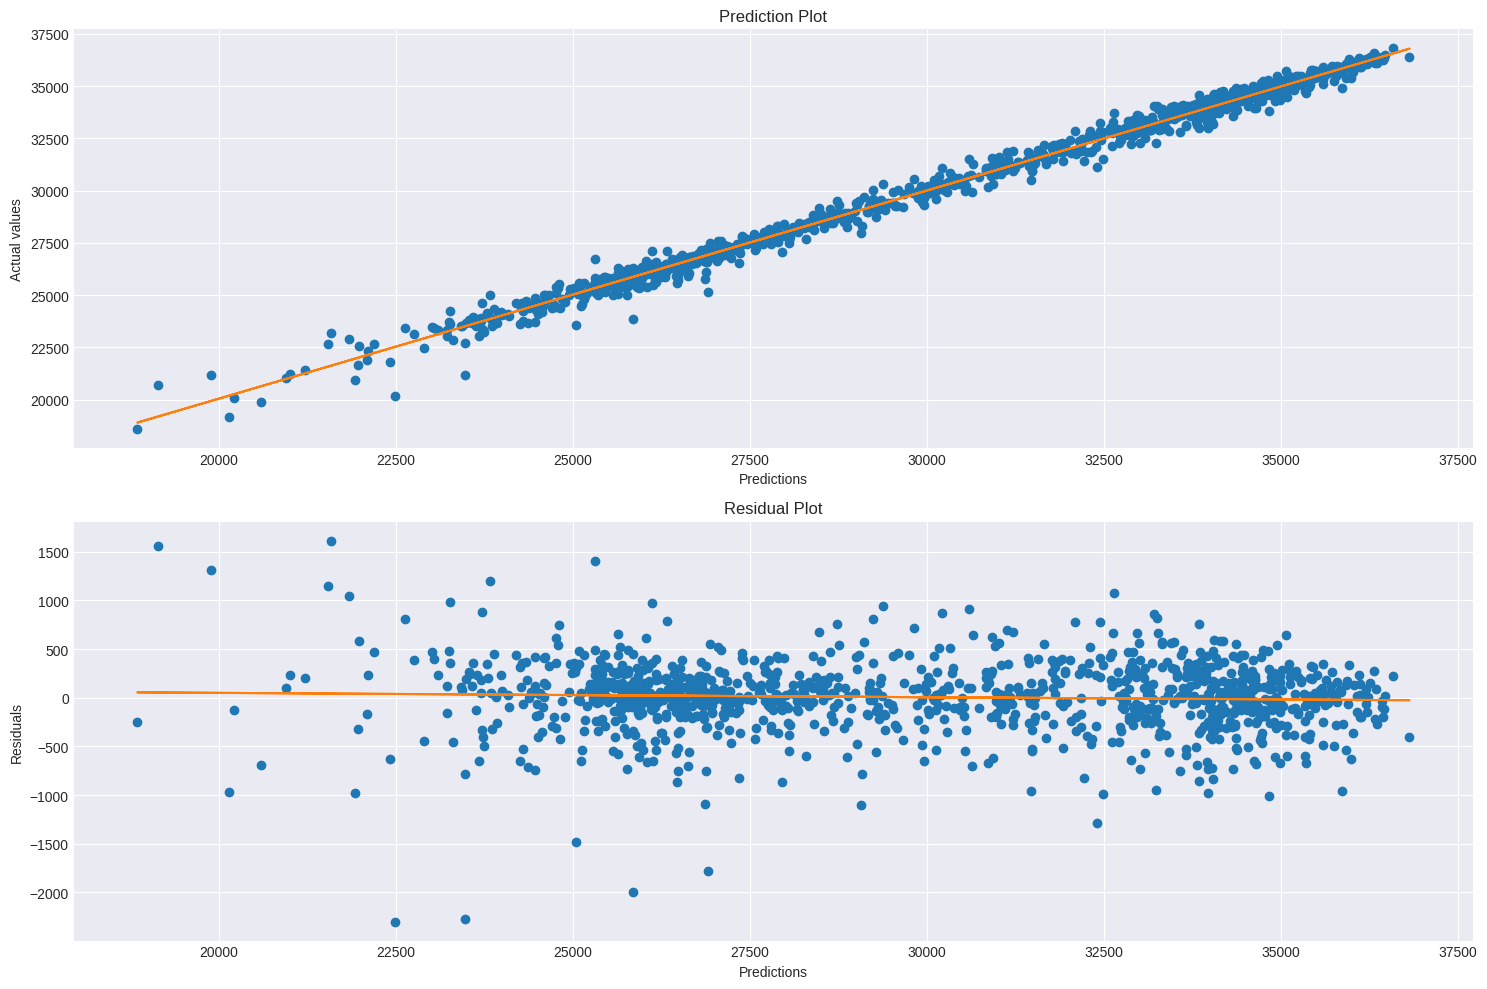

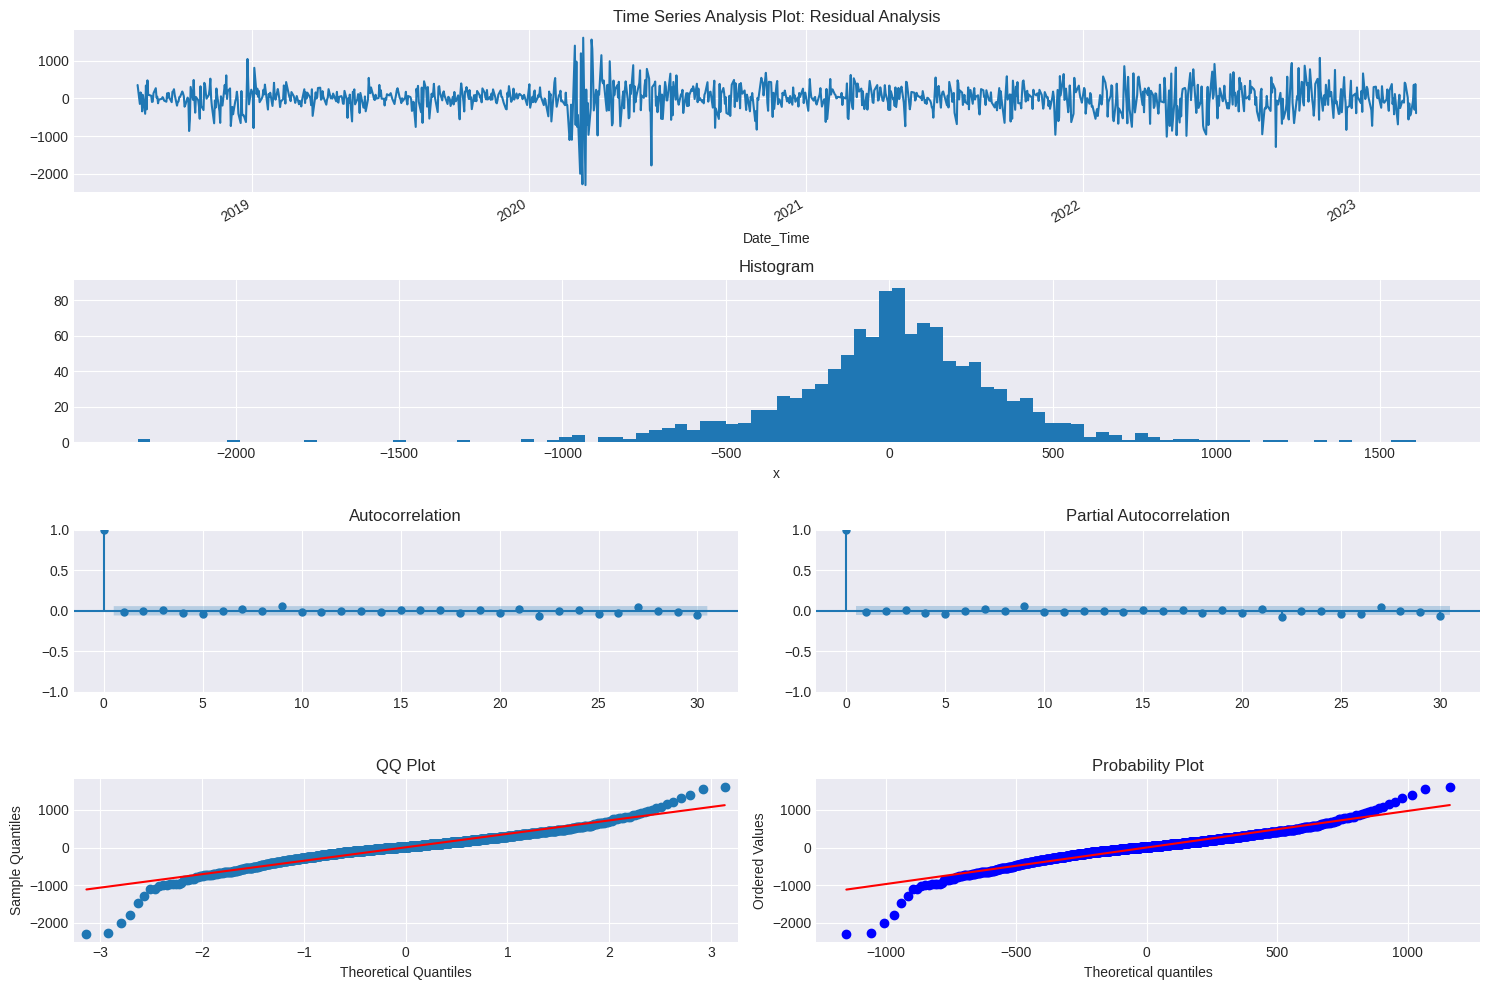


Prediction Metrics

Mean Forecast Error (MFE): 5.740779450486766
Mean Absolute Error (MAE): 249.77178129485947
Max. Error: 2299.4801595343197
Residual Standard Error (RSE): 356.63348320804556
Mean Absolute Percentage Error (MAPE): 0.008681925008306024
Mean Absolute Standard Error (MASE): 0.9996955792553386

R-Squared: 0.9918752485061046
Mean Directional Accuracy (MDA): 0.540447504302926%
Mean Sign Accuracy (MSA): 1.%

Directional Metrics

Won : 1163.0
Lost : 0.0
Total : 1163.0
Diff : 1163.0
Edge : 100.0%
IR : 34.102787
Accuracy: 100.00%



In [13]:
##
# PRICE DATA
# Run the ARIMA fit to find the best paramters
# Generate metrics and plots to assess
##
from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

y = p.findAsset("DOW").values["Close"]

im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y})).generateInsights()
yhat = result["ARIMAFit"].predict()

im = InsightManager(p)
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"predictions": yhat[1:], "actuals": y[1:]}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"predictions": yhat[1:], "actual": y[1:]}))

results = im.generateInsights()

ARIMA:3,1,2, AIC:-6744.088943696066, MFE:0.008893682970167138, MAE:0.0175179327130377
Model Parameters


ar.L1    -1.037211
ar.L2    -0.014907
ar.L3     0.223639
ma.L1     0.923589
ma.L2     0.049321
sigma2    0.000176
dtype: float64

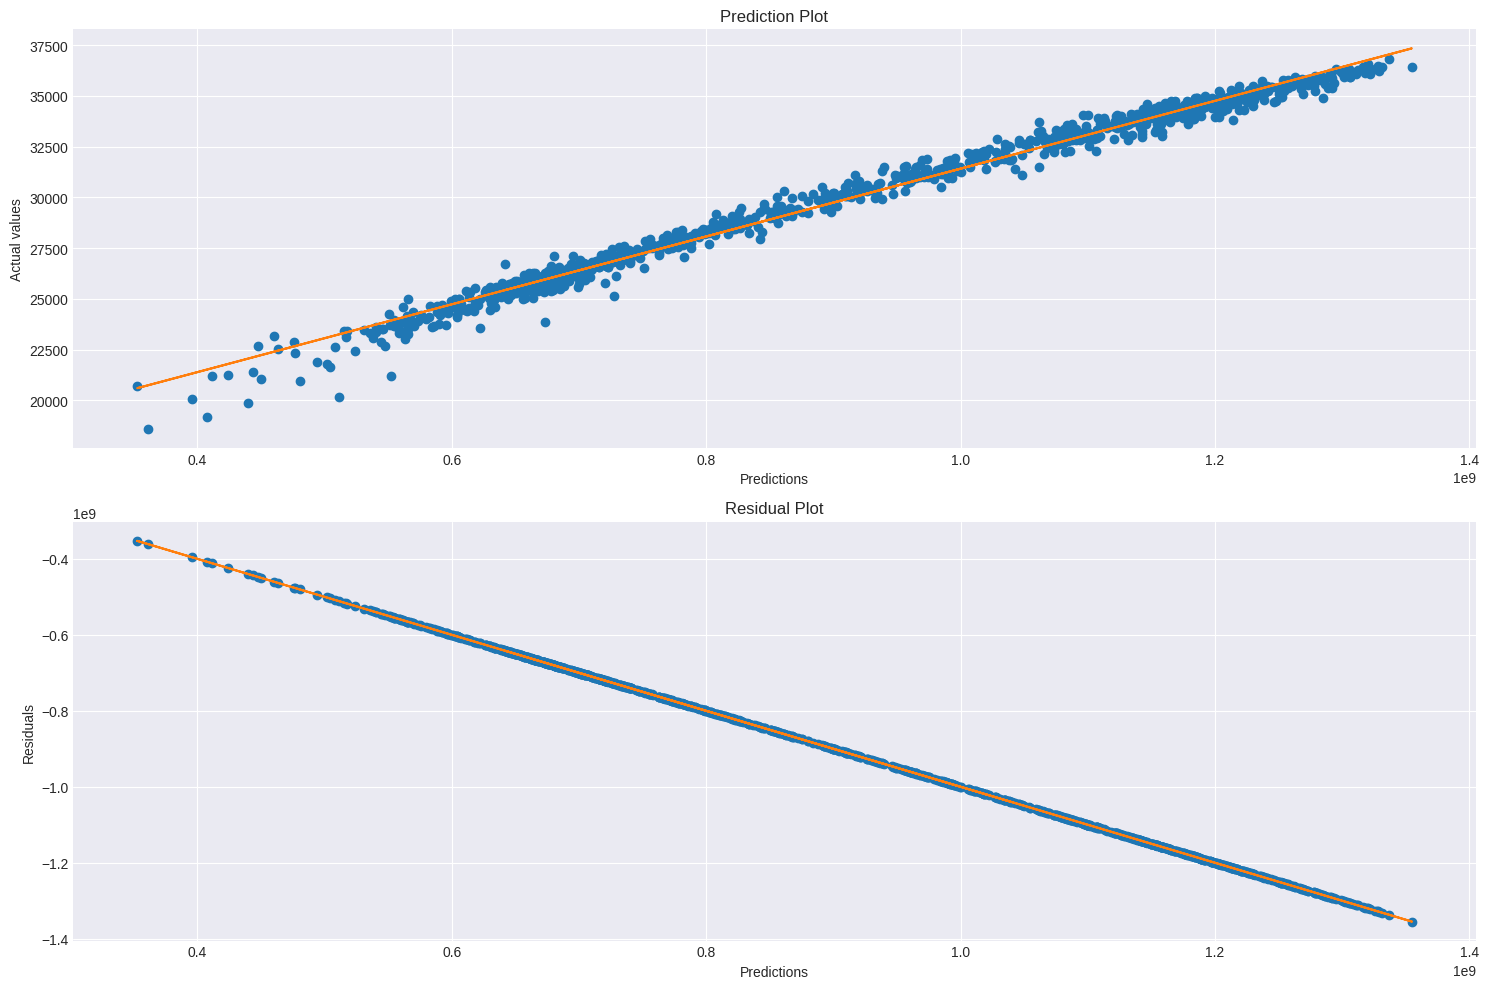

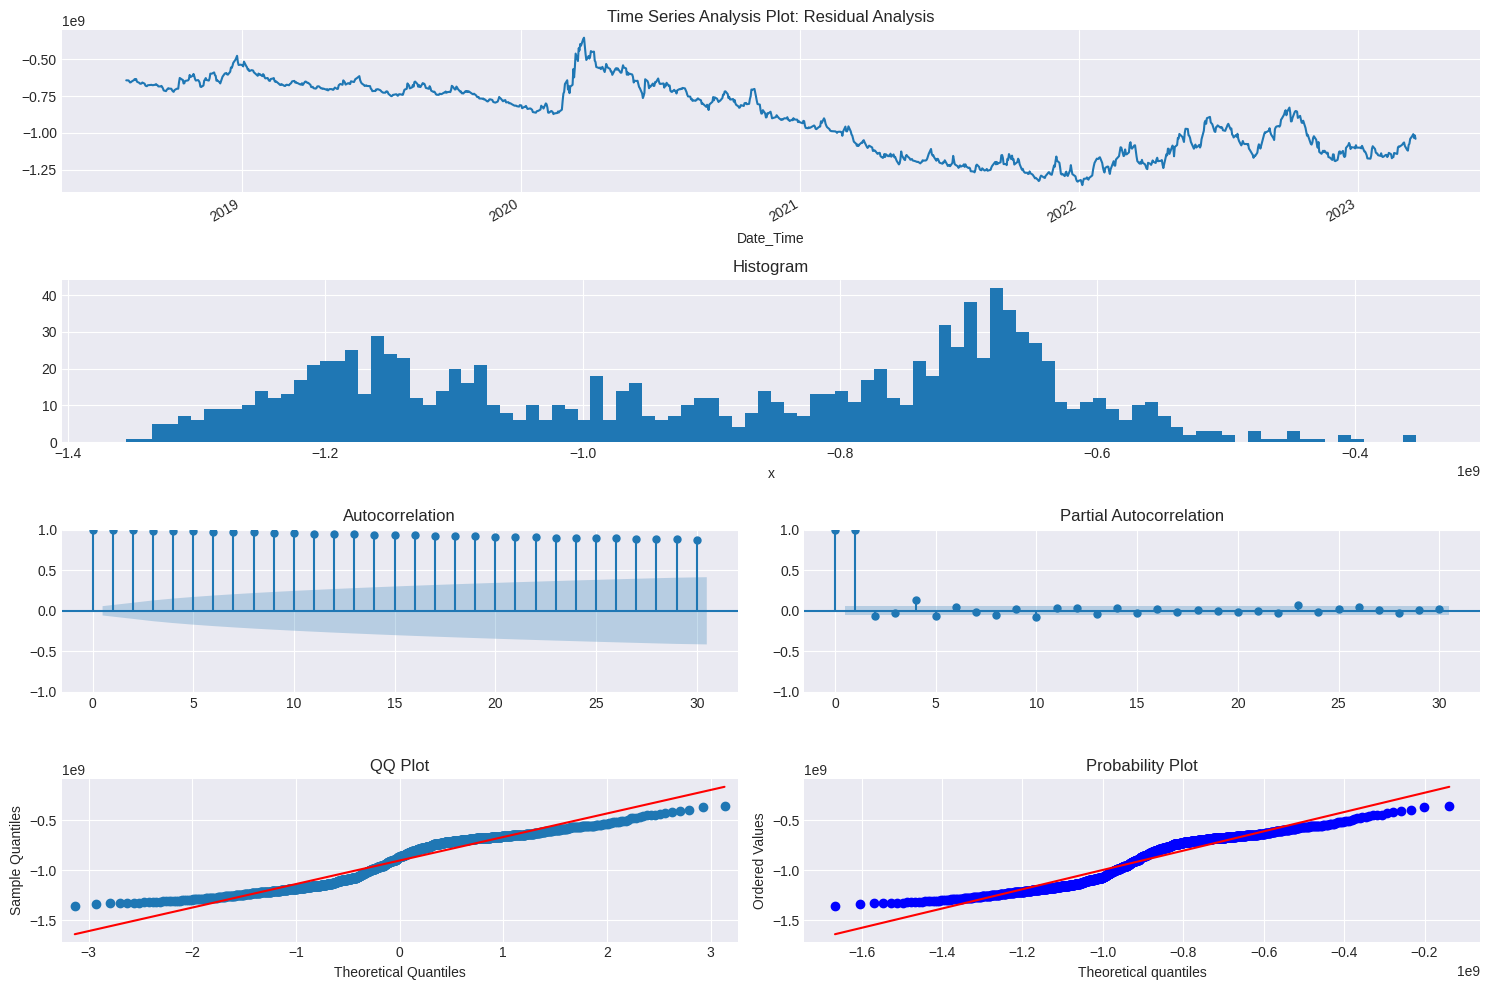


Prediction Metrics

Mean Forecast Error (MFE): -902206962.3220636
Mean Absolute Error (MAE): 902206962.3220636
Max. Error: 1354727142.9682114
Residual Standard Error (RSE): 932455544.7047267
Mean Absolute Percentage Error (MAPE): 29773.71004643073
Mean Absolute Standard Error (MASE): 3611025.6616299246

R-Squared: -55542078418.98944
Mean Directional Accuracy (MDA): 0.5378657487091222%
Mean Sign Accuracy (MSA): 1.%

Directional Metrics

Won : 1163.0
Lost : 0.0
Total : 1163.0
Diff : 1163.0
Edge : 100.0%
IR : 34.102787
Accuracy: 100.00%



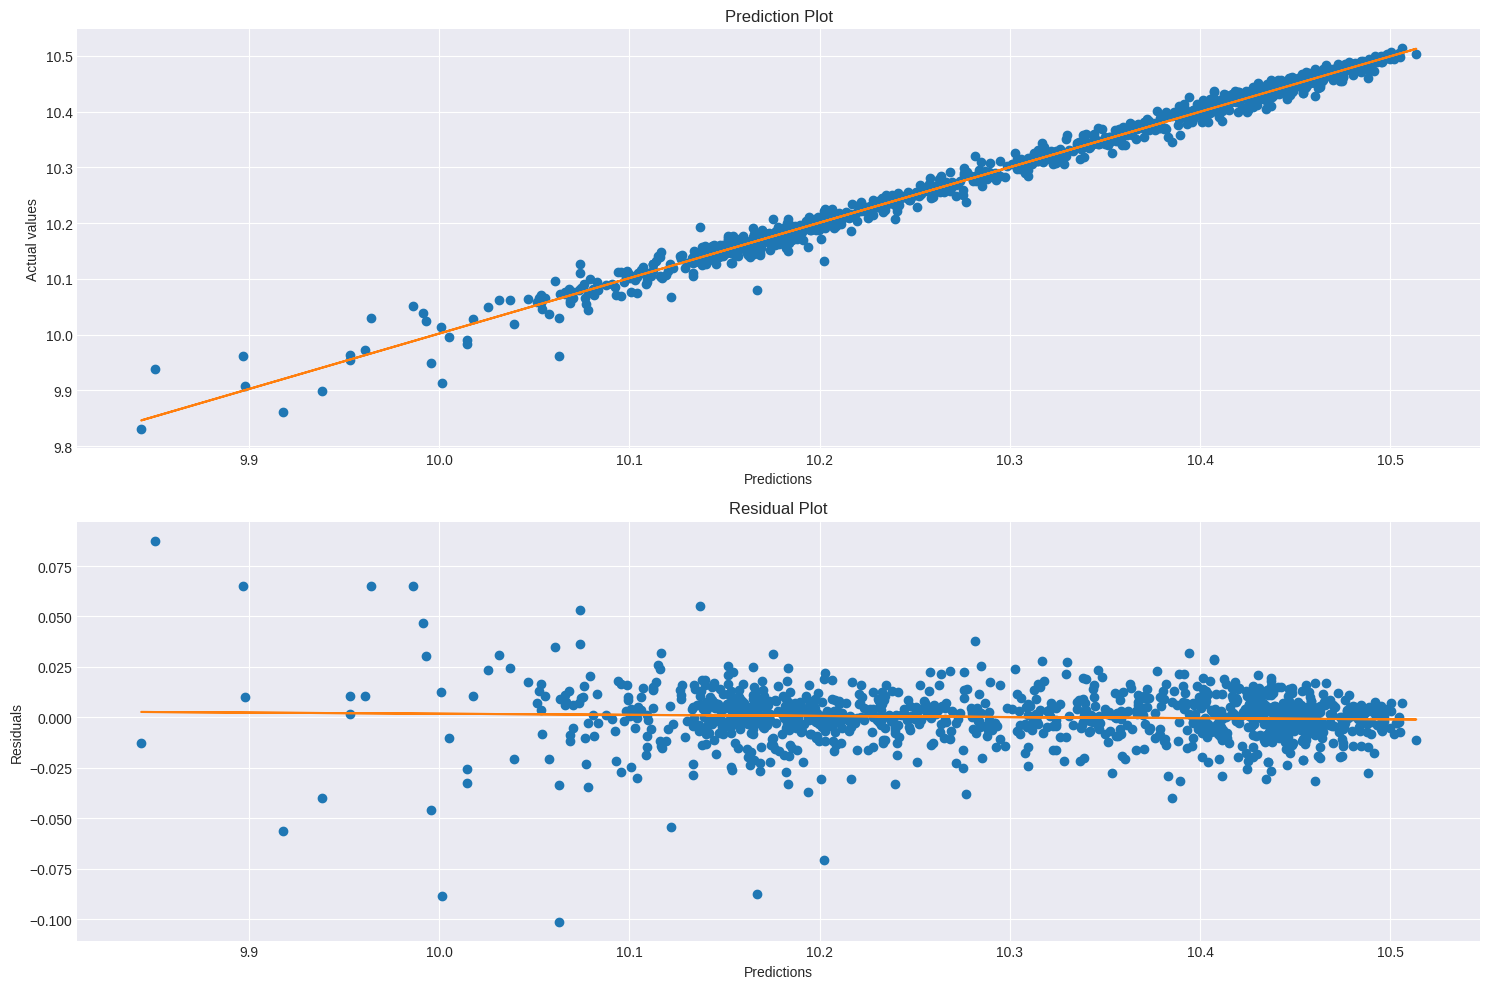

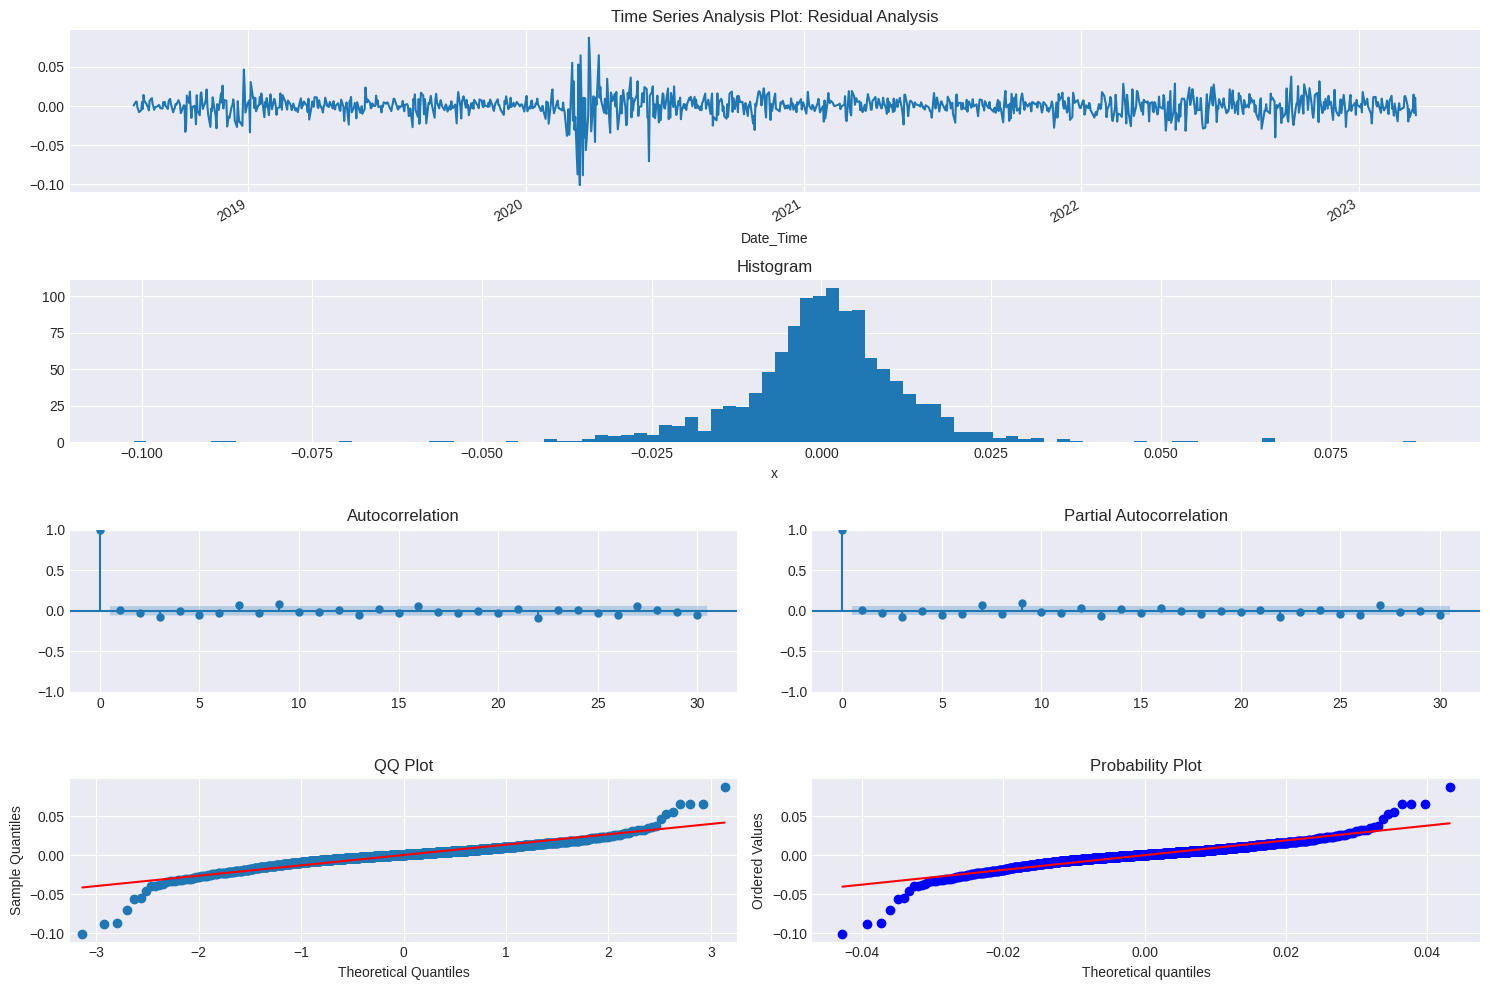


Prediction Metrics

Mean Forecast Error (MFE): 0.00018214214828340006
Mean Absolute Error (MAE): 0.008813807411139235
Max. Error: 0.1012024973352652
Residual Standard Error (RSE): 0.013251142949404342
Mean Absolute Percentage Error (MAPE): 0.0008594976024243629
Mean Absolute Standard Error (MASE): 1.0087206761703686

R-Squared: 0.9903627323060284
Mean Directional Accuracy (MDA): 0.5111876075731497%
Mean Sign Accuracy (MSA): 1.%

Directional Metrics

Won : 1163.0
Lost : 0.0
Total : 1163.0
Diff : 1163.0
Edge : 100.0%
IR : 34.102787
Accuracy: 100.00%



In [5]:
##
# LOG PRICE DATA
# Run the ARIMA fit to find the best paramters
# Generate metrics and plots to assess
##

from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

def inv_trans(y, yhat):
    return np.exp(np.log(y).shift() + yhat)[1:]

def trans(y):
    return np.log(y)

y = p.findAsset("DOW").values["Close"]
y_trans = trans(y)

im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y_trans, "order":(3,1,2)})).generateInsights()
yhat_trans = result["ARIMAFit"].predict()[1:]
yhat = inv_trans(y, yhat_trans)


im = InsightManager(p)
# FIRST ASSES UNTRANSFORMED RESULTS
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"predictions": yhat, "actuals": y[1:]}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"predictions": yhat, "actual": y[1:]}))

# NOW ASSESS TRANSFORMED RESULTS
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"predictions": yhat_trans, "actuals": y_trans[1:]}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"predictions": yhat_trans, "actual": y_trans[1:]}))

results = im.generateInsights()

ARIMA:3,0,2, AIC:-6753.885295079853, MFE:7.508763266641597e-05, MAE:0.008683663572744289
Model Parameters


const     0.000120
ar.L1    -1.359069
ar.L2    -0.396997
ar.L3     0.144992
ma.L1     1.269573
ma.L2     0.422298
sigma2    0.000173
dtype: float64

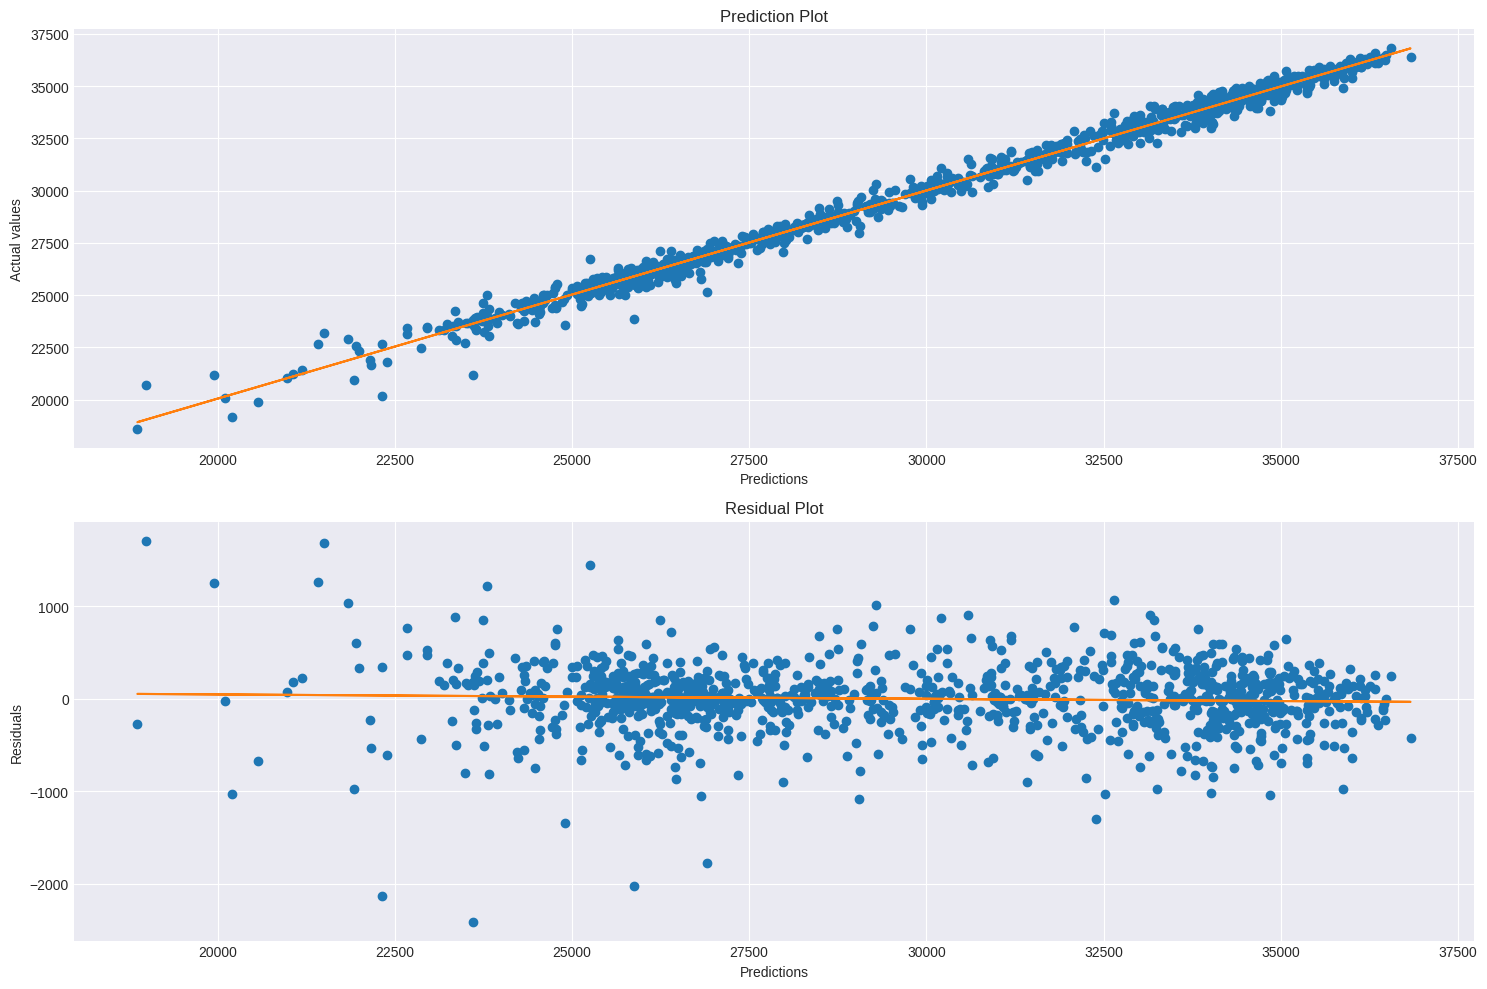

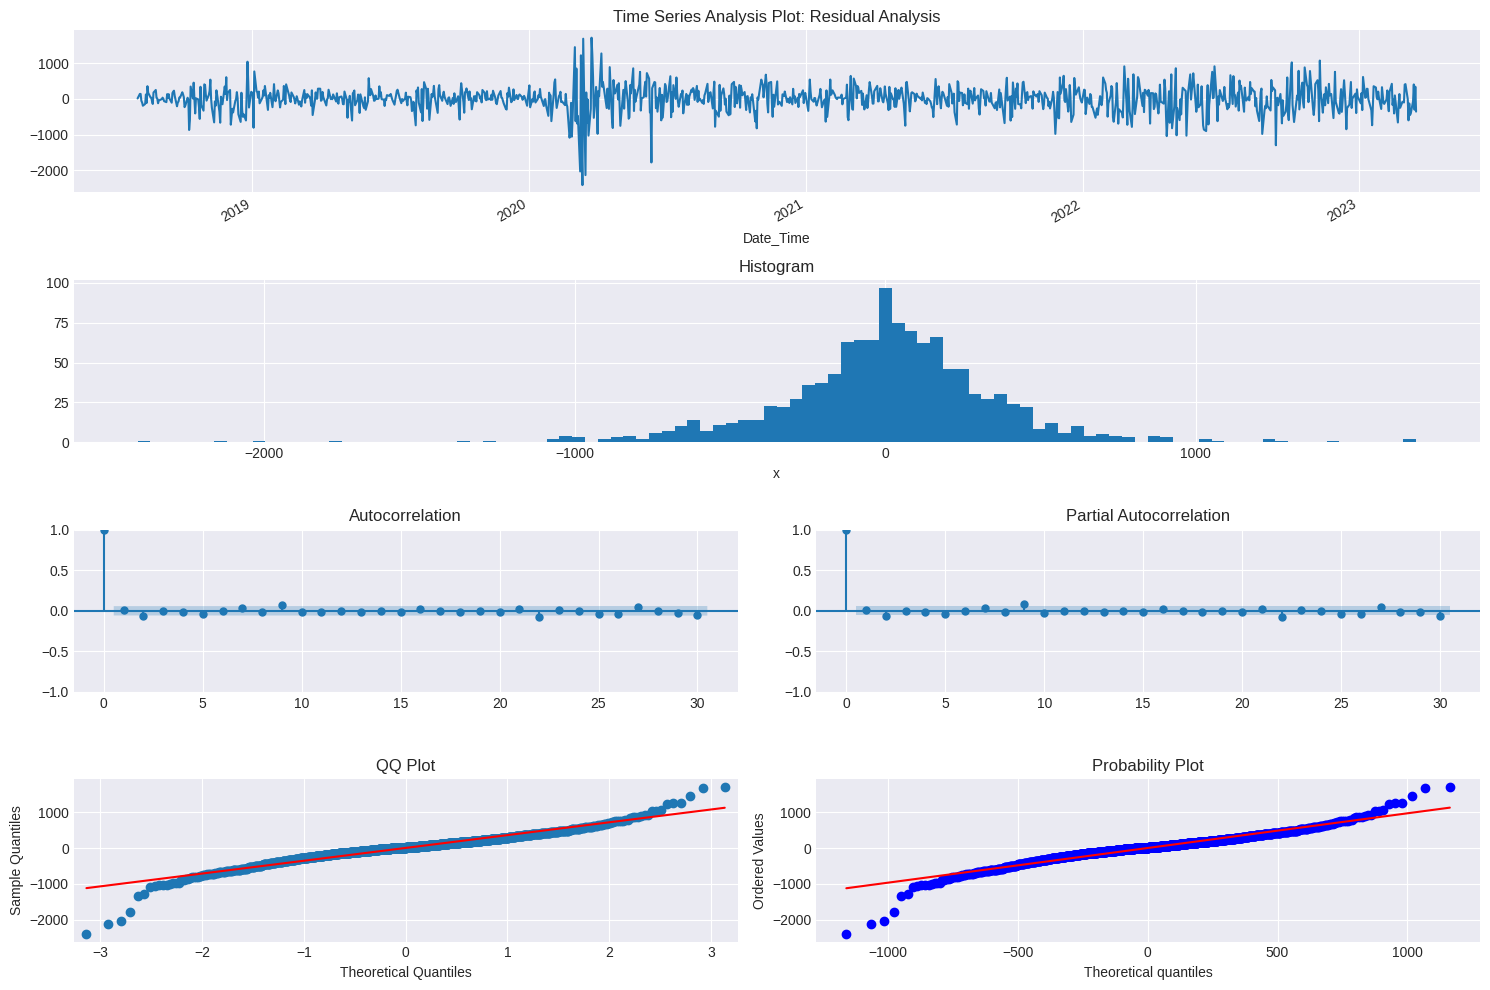


Prediction Metrics

Mean Forecast Error (MFE): 1.9375997913645318
Mean Absolute Error (MAE): 250.42838041510652
Max. Error: 2408.423378249343
Residual Standard Error (RSE): 358.08091854250046
Mean Absolute Percentage Error (MAPE): 0.008694106162251213
Mean Absolute Standard Error (MASE): 1.0023235752381154

R-Squared: 0.9918091643178875
Mean Directional Accuracy (MDA): 0.5292598967297762%
Mean Sign Accuracy (MSA): 1.%

Directional Metrics

Won : 1163.0
Lost : 0.0
Total : 1163.0
Diff : 1163.0
Edge : 100.0%
IR : 34.102787
Accuracy: 100.00%



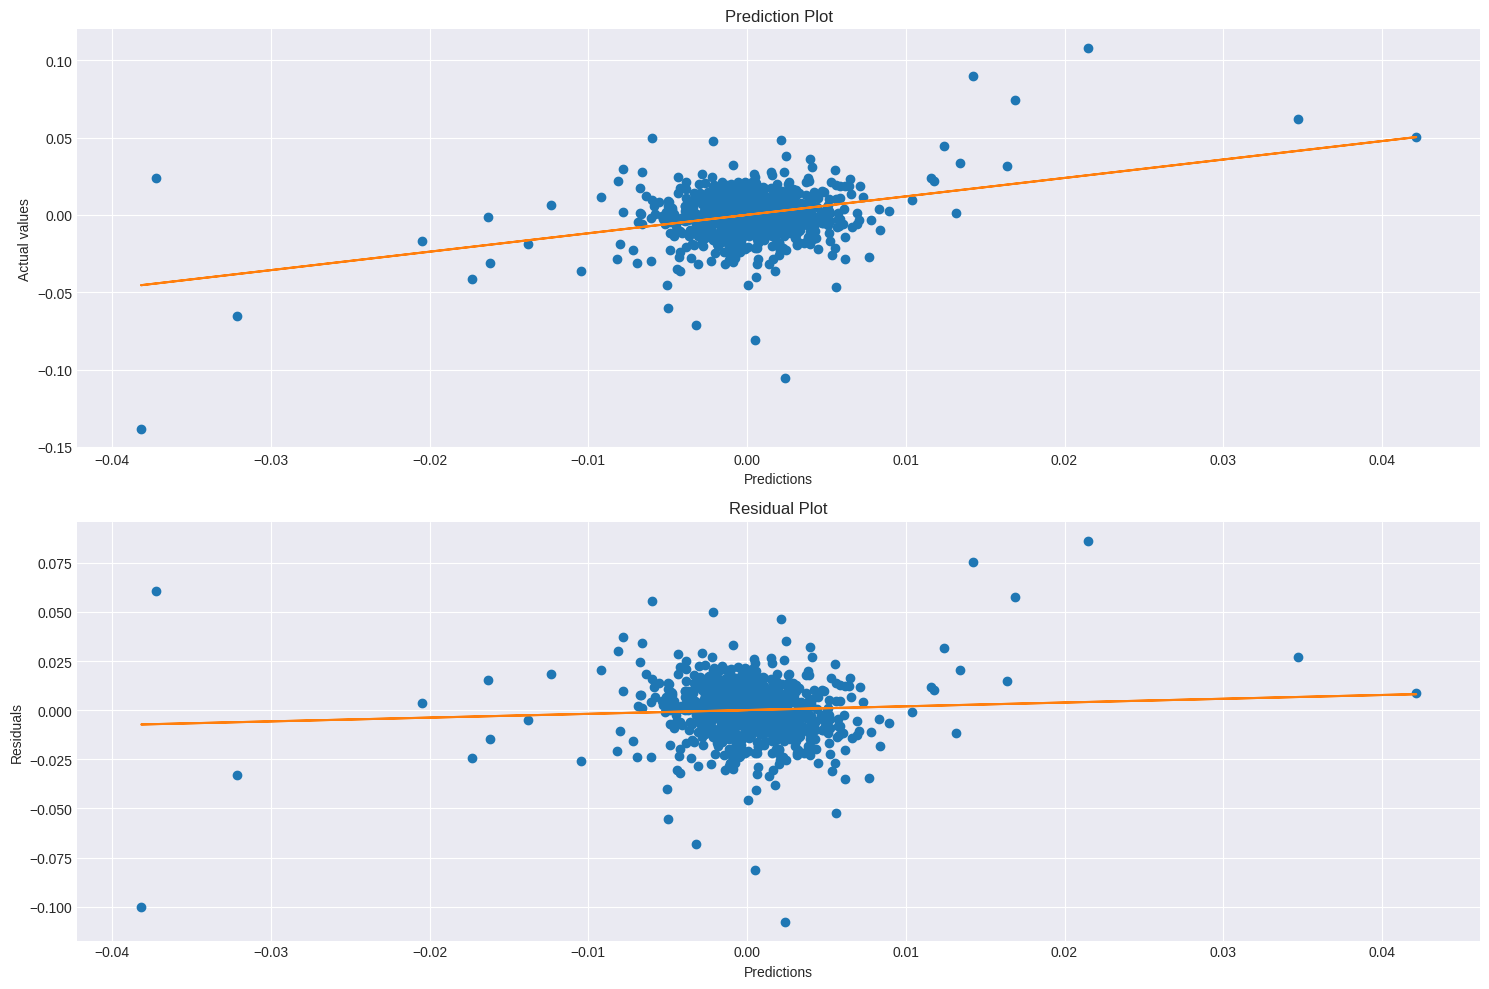

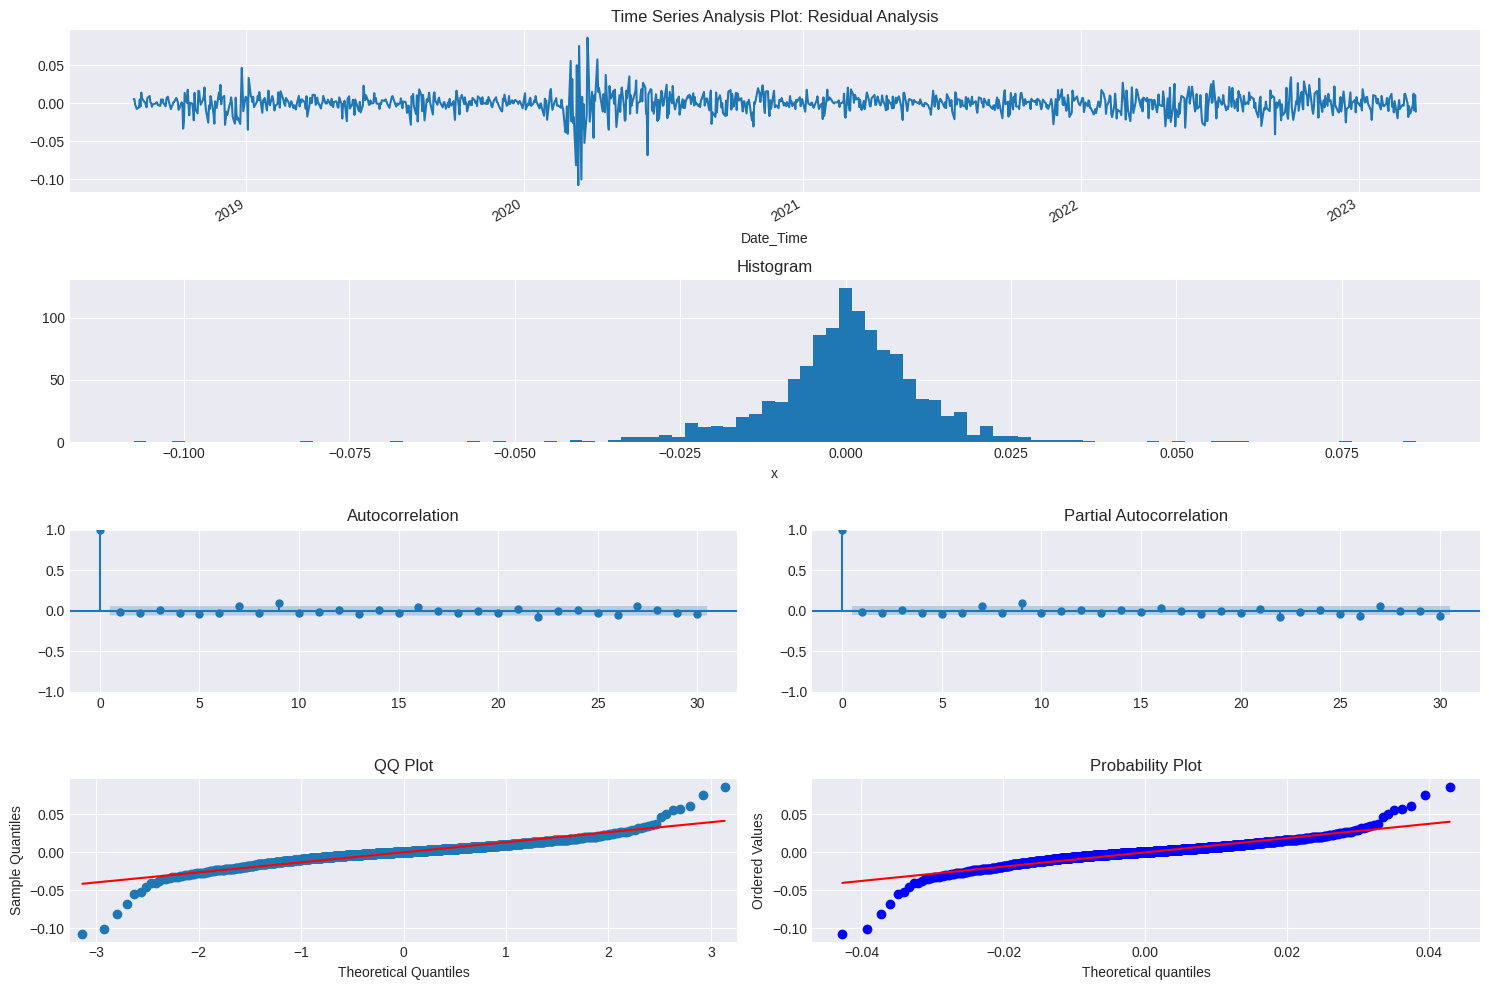


Prediction Metrics

Mean Forecast Error (MFE): 0.00007472919496812854
Mean Absolute Error (MAE): 0.008690713548075327
Max. Error: 0.10759596174187731
Residual Standard Error (RSE): 0.013190116730028357
Mean Absolute Percentage Error (MAPE): 3955049246.1248074
Mean Absolute Standard Error (MASE): 0.6720575870529135

R-Squared: 0.10859403532073009
Mean Directional Accuracy (MDA): 0.7493540051679587%
Mean Sign Accuracy (MSA): 0.5292598967297762%

Directional Metrics

Won : 615.0
Lost : 547.0
Total : 1162.0
Diff : 68.0
Edge : 5.851979345955249%
IR : 1.9948297
Accuracy: 52.93%



In [6]:
##
# LOG AND DIFFERENCED PRICE DATA
# Run the ARIMA fit to find the best paramters
# Generate metrics and plots to assess
##

from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

def inv_trans(y, yhat):
    return np.exp(np.log(y).shift() + yhat)[1:]

def trans(y):
    return np.log(y).diff()[1:]

y = p.findAsset("DOW").values["Close"]
y_trans = trans(y)

im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y_trans, "order":(3,0,2)})).generateInsights()
yhat_trans = result["ARIMAFit"].predict()
yhat = inv_trans(y, yhat_trans)


im = InsightManager(p)
# FIRST ASSESS UNTRANSFORMED RESULTS
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"predictions": yhat, "actuals": y[1:]}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"predictions": yhat, "actual": y[1:]}))

# NOW ASSESS TRANSFORMED RESULTS
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"predictions": yhat_trans[1:], "actuals": y_trans[1:]}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"predictions": yhat_trans[1:], "actual": y_trans[1:]}))

results = im.generateInsights()


ARIMA:3,0,2, AIC:-7476.915569419159, MFE:4.724642537305177e-06, MAE:0.006778449628889783
Model Parameters


const     0.000731
ar.L1     0.725479
ar.L2    -0.742683
ar.L3     0.047368
ma.L1    -0.667124
ma.L2     0.781850
sigma2    0.000094
dtype: float64

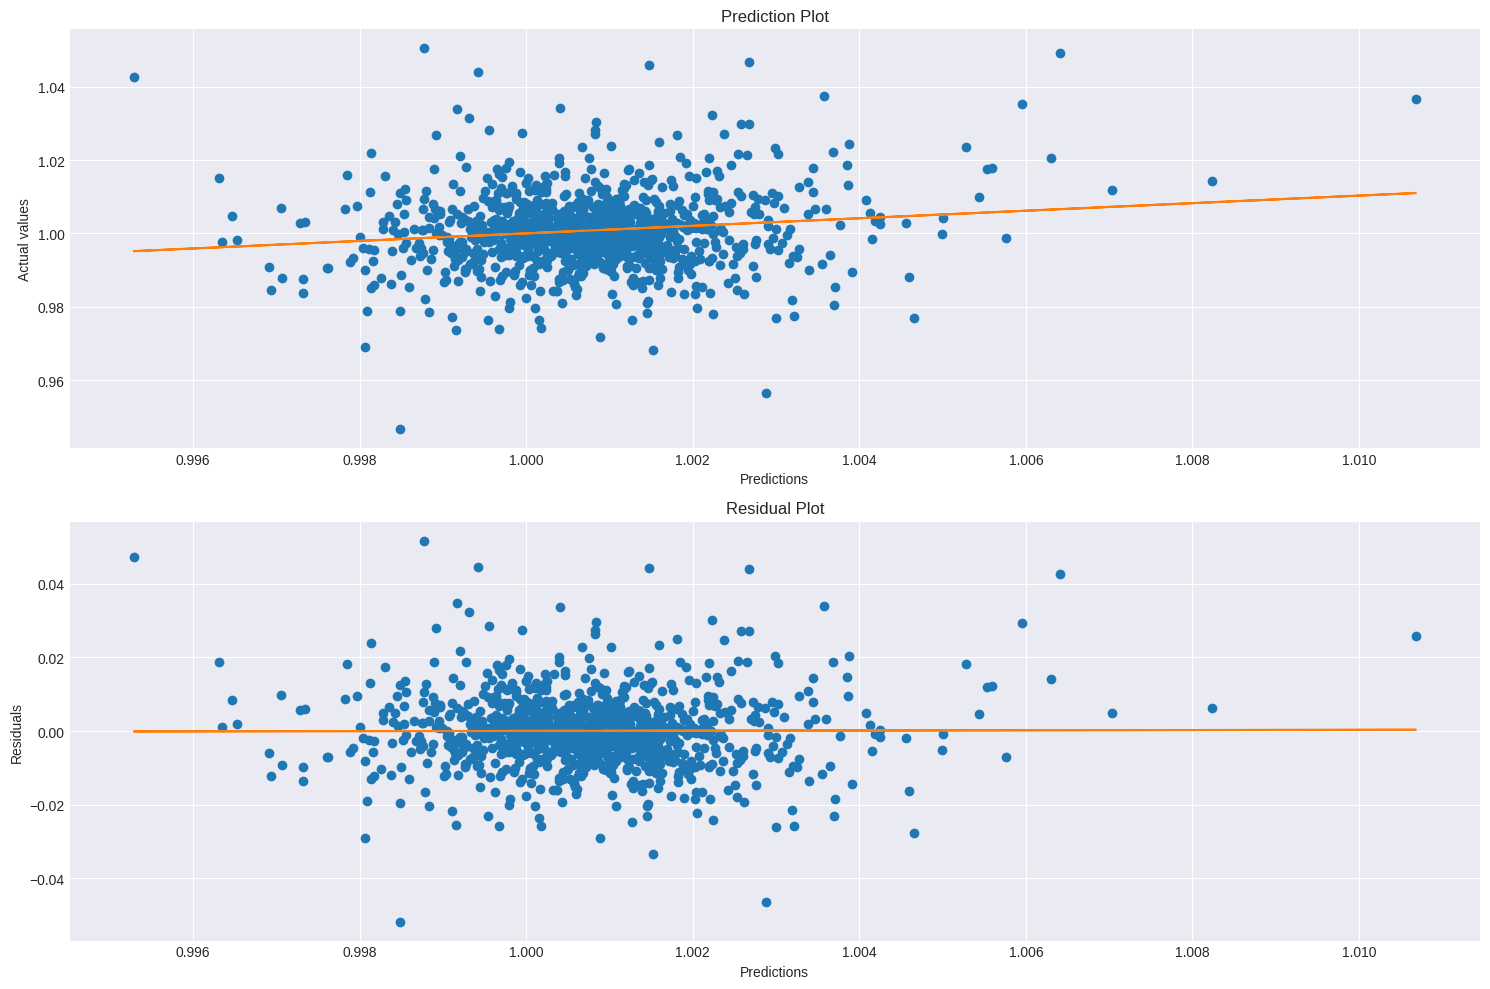

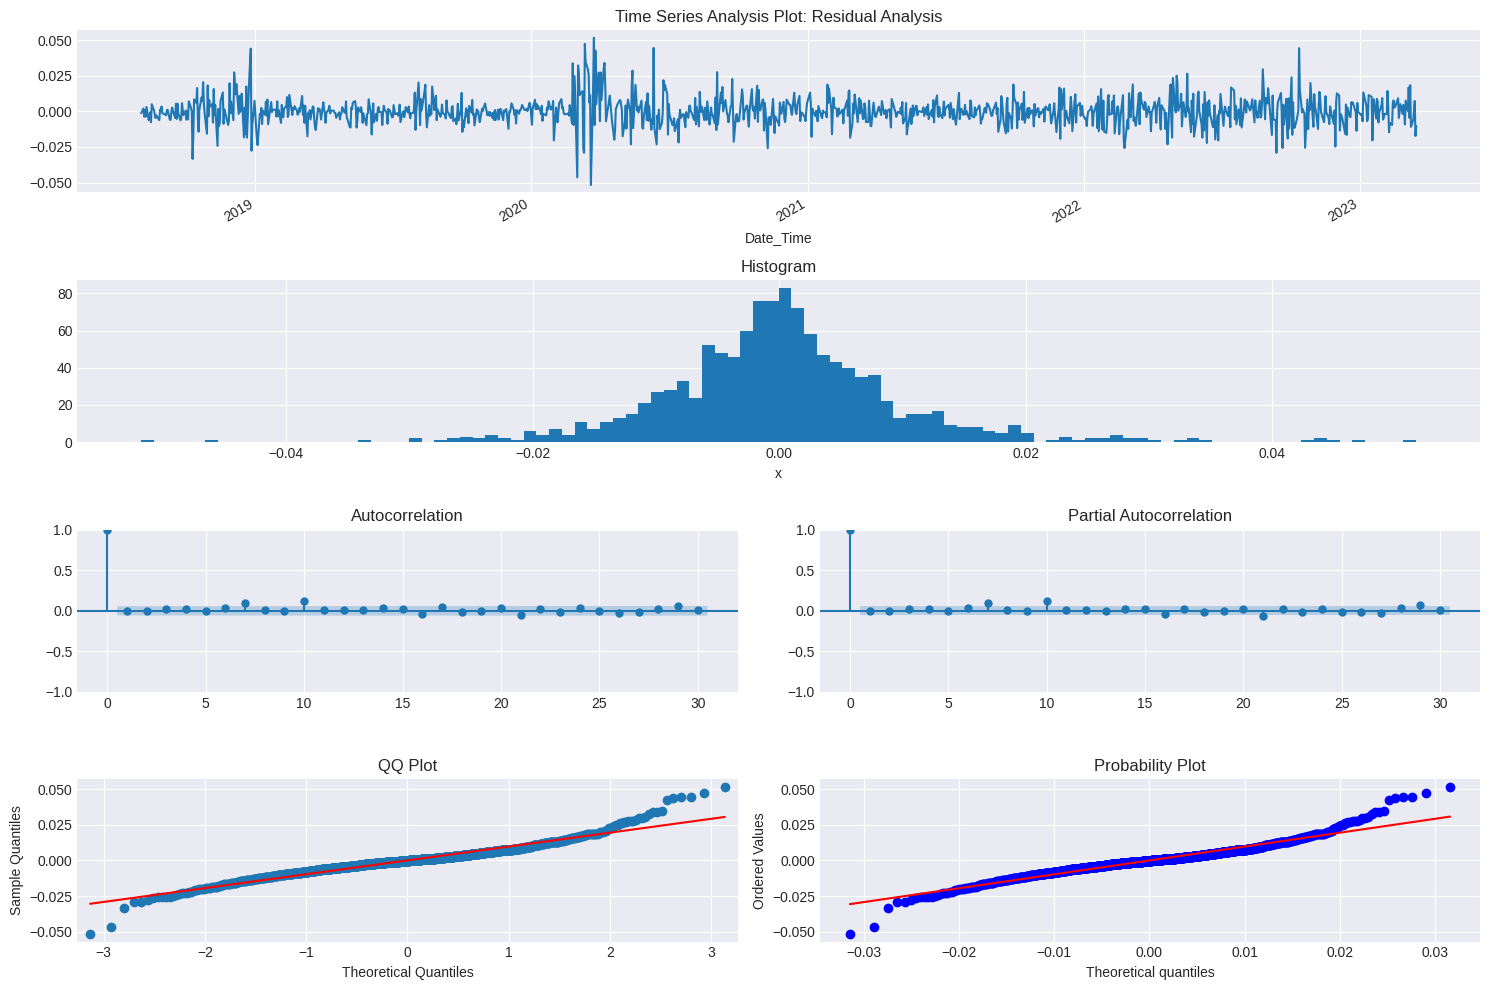


Prediction Metrics

Mean Forecast Error (MFE): 0.00005248455813926893
Mean Absolute Error (MAE): 0.006793241781422212
Max. Error: 0.05177102897141128
Residual Standard Error (RSE): 0.009721503903063252
Mean Absolute Percentage Error (MAPE): 0.006780397448005389
Mean Absolute Standard Error (MASE): 0.7161290471913984

R-Squared: 0.020124107454334128
Mean Directional Accuracy (MDA): 0.7314974182444062%
Mean Sign Accuracy (MSA): 1.%

Directional Metrics

Won : 1163.0
Lost : 0.0
Total : 1163.0
Diff : 1163.0
Edge : 100.0%
IR : 34.102787
Accuracy: 100.00%



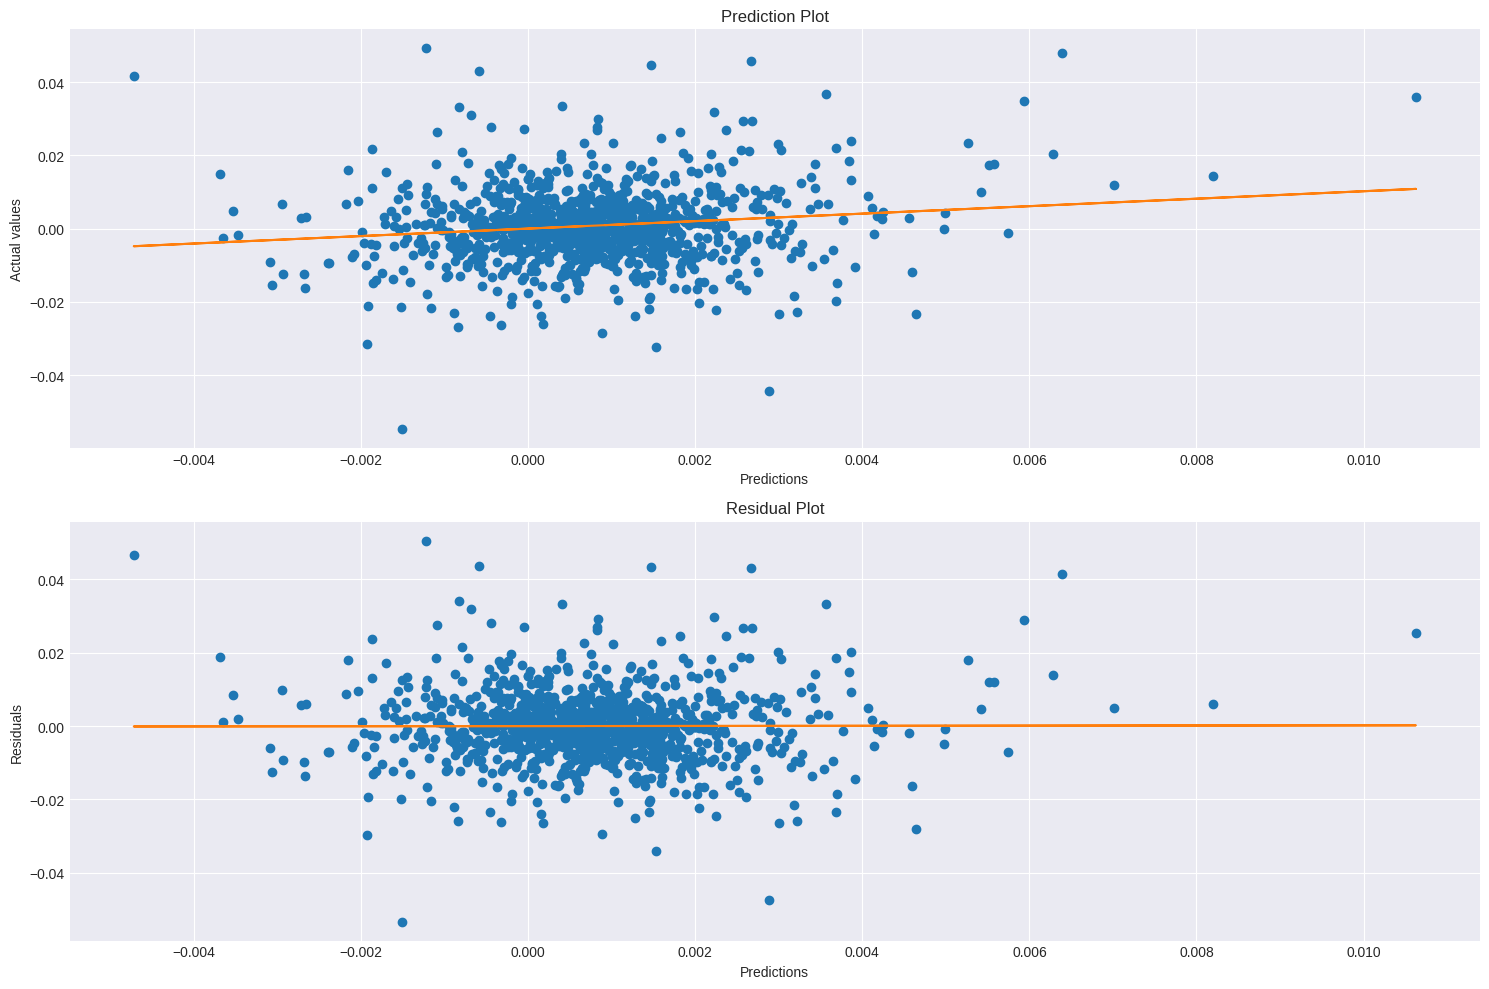

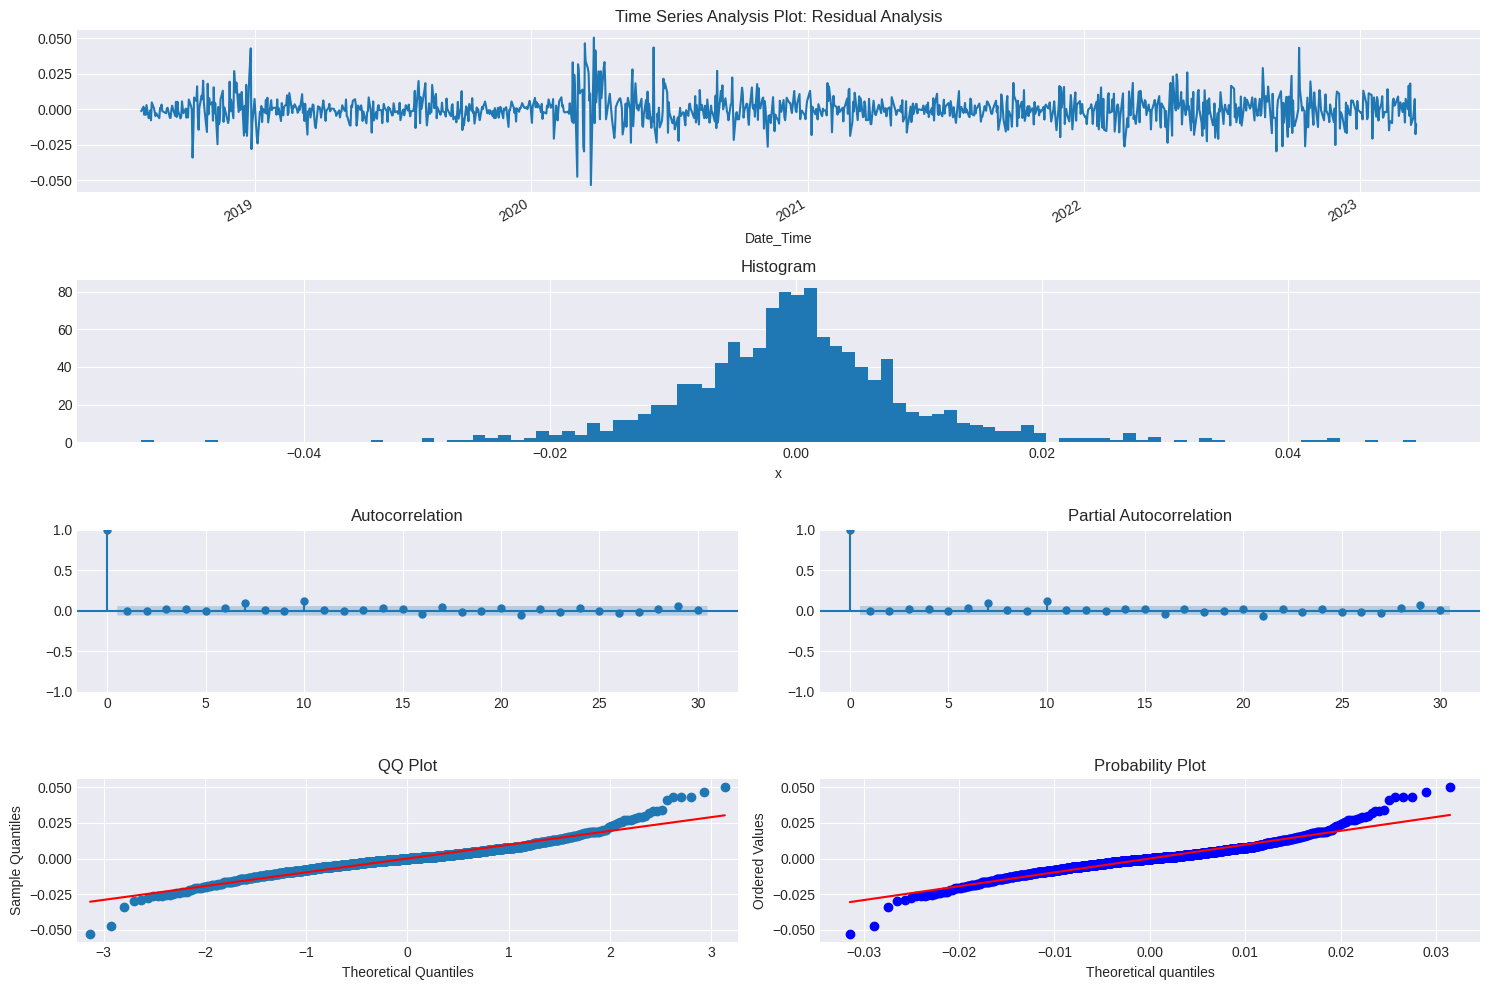


Prediction Metrics

Mean Forecast Error (MFE): 0.000005357213793313636
Mean Absolute Error (MAE): 0.006783649537660796
Max. Error: 0.053242011576205374
Residual Standard Error (RSE): 0.00969359043487061
Mean Absolute Percentage Error (MAPE): 2.8112048351222576
Mean Absolute Standard Error (MASE): 0.7159659317889542

R-Squared: 0.019886183126692103
Mean Directional Accuracy (MDA): 0.7314974182444062%
Mean Sign Accuracy (MSA): 0.529664660361135%

Directional Metrics

Won : 616.0
Lost : 547.0
Total : 1163.0
Diff : 69.0
Edge : 5.932932072226999%
IR : 2.0232952
Accuracy: 52.97%



In [7]:
##
# LOG RETURNS DATA
# Run the ARIMA fit to find the best paramters
# Generate metrics and plots to assess
##

from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

y_trans = utils.getPeriodLogReturns(p.returns)["period"]
im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y_trans, "order":(3,0,2)})).generateInsights()
resid = result["ARIMAFit"].resid[1:]
yhat_trans = result["ARIMAFit"].predict()[1:]
yhat = np.exp(yhat_trans)
y = np.exp(y_trans)[1:]


im = InsightManager(p)

# FIRST ASSESS UNTRANSFORMED RESULTS
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"predictions": yhat, "actuals": y}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"predictions": yhat, "actual": y}))

# NOW ASSESS TRANSFORMED RESULTS
im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"predictions": yhat_trans, "actuals": y_trans[1:]}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"predictions": yhat_trans, "actual": y_trans[1:]}))

results = im.generateInsights()

ARIMA:3,0,2, AIC:-7476.915569419159, MFE:4.724642537305177e-06, MAE:0.006778449628889783
Model Parameters


const     0.000731
ar.L1     0.725479
ar.L2    -0.742683
ar.L3     0.047368
ma.L1    -0.667124
ma.L2     0.781850
sigma2    0.000094
dtype: float64

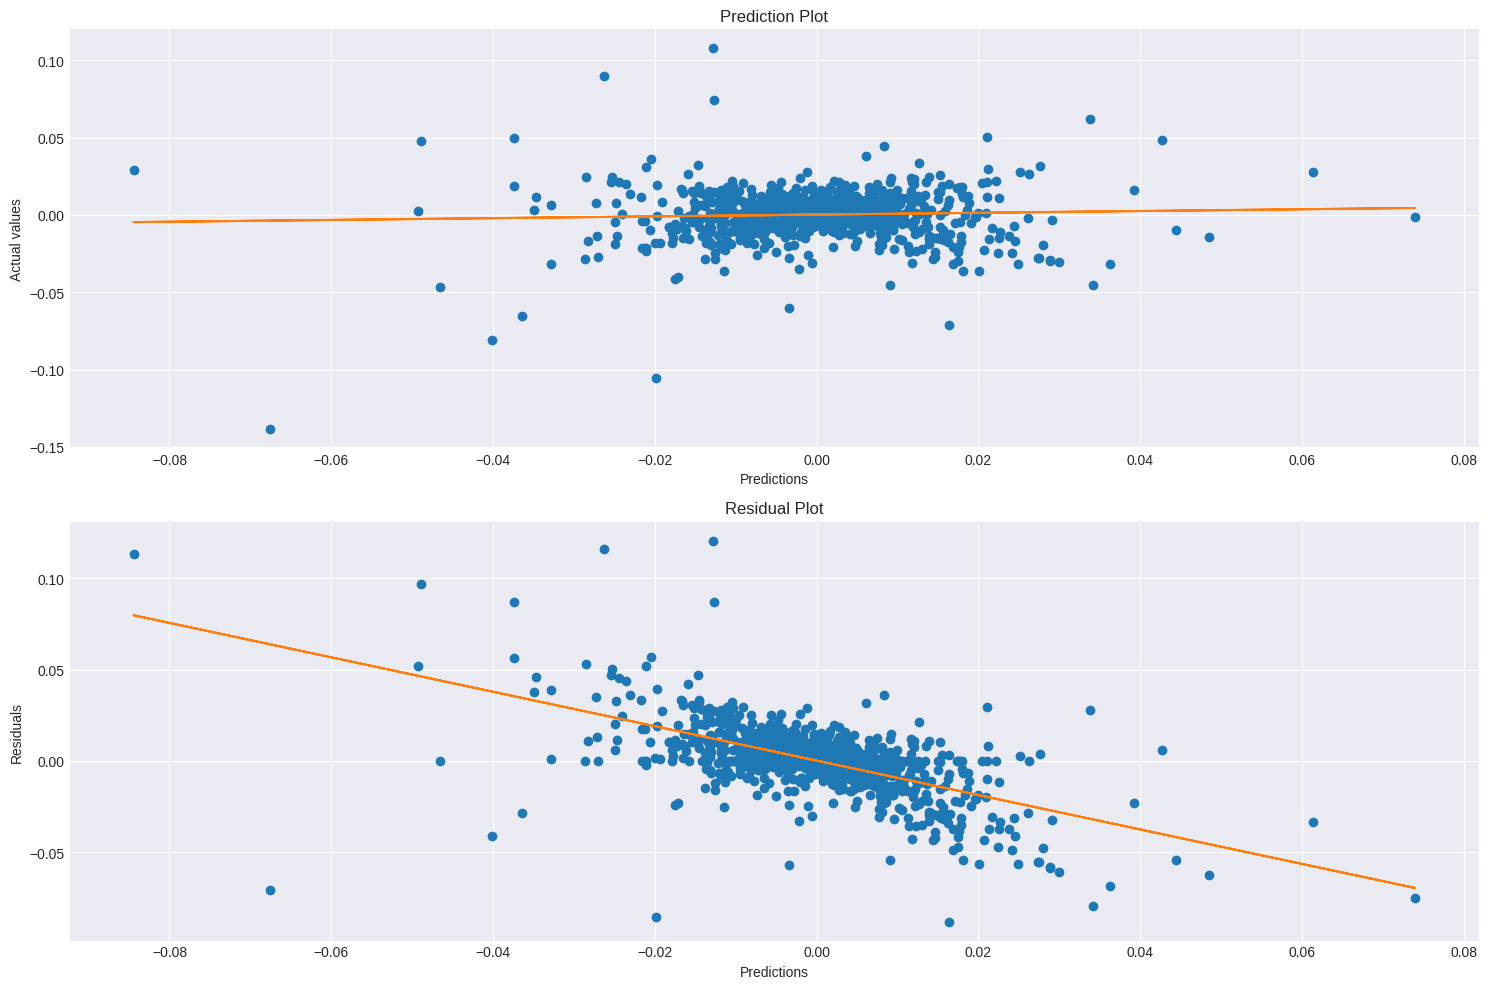

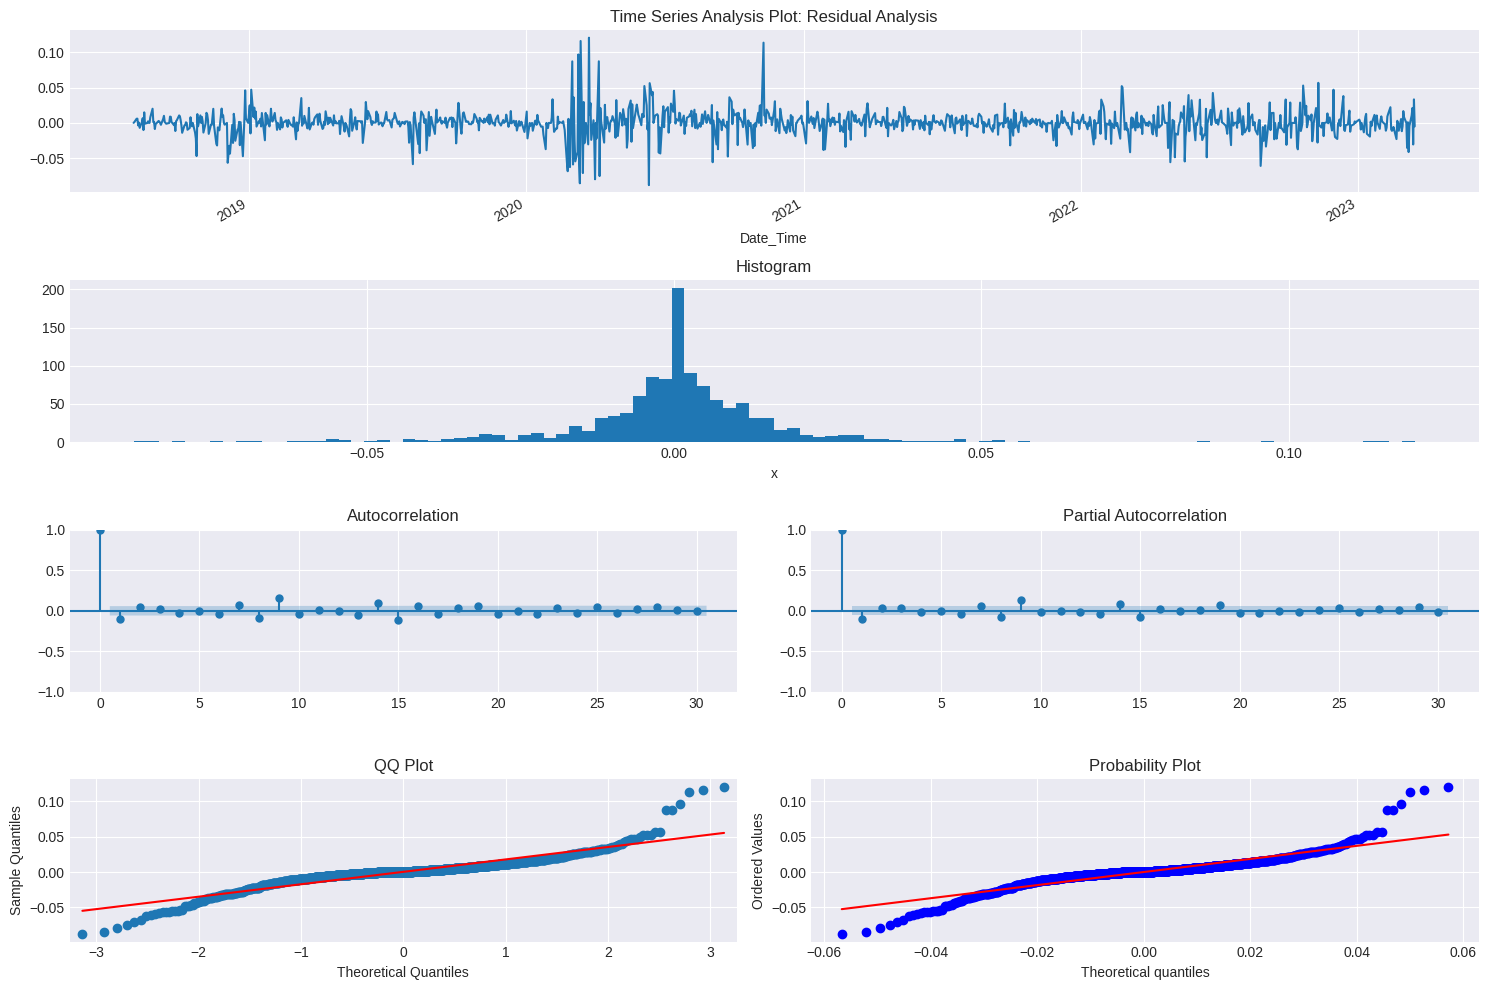


Prediction Metrics

Mean Forecast Error (MFE): 0.00025894573870542014
Mean Absolute Error (MAE): 0.010638521993016993
Max. Error: 0.12049348691193318
Residual Standard Error (RSE): 0.017566215044590387
Mean Absolute Percentage Error (MAPE): 2822356421.538773
Mean Absolute Standard Error (MASE): 0.823802062055064

R-Squared: -0.5837300321717425
Mean Directional Accuracy (MDA): 0.6947549441100602%
Mean Sign Accuracy (MSA): 0.5146048109965635%

Directional Metrics

Won : 599.0
Lost : 565.0
Total : 1164.0
Diff : 34.0
Edge : 2.9209621993127146%
IR : 0.9965576
Accuracy: 51.46%



In [12]:
##
# UNDERLYING LOG RETURNS VS BASELINE
# Generate metrics and plots to assess
##

from tradeframework.api.insights import InsightManager
import warnings
warnings.filterwarnings("ignore")

im = InsightManager(p)
result = im.addInsightGenerator(im.createInsightGenerator("ARIMAFit", opts={"series": y_trans, "order":(3,0,2)})).generateInsights()

im = InsightManager(p)

im.addInsightGenerator(im.createInsightGenerator("PredictionPlot", opts={"baseline":p.assets[0]}))
im.addInsightGenerator(im.createInsightGenerator("PredictionMetrics", opts={"baseline":p.assets[0]}))

results = im.generateInsights()

In [33]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 9498#24*5*4*3
x = x.iloc[-window-100:]
r = len(x) - window
predictions = np.array([sm.tsa.arima.ARIMA(x[i:i+window]["Close"].values, order=(3, 1, 5)).fit().forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

array([ 1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.])

In [238]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-1000:]
r = len(x) - window
params = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit().params
predictions = np.array([sm.tsa.arima.ARIMA(x[i:i+window]["Close"].values, order=(3, 1, 5)).filter(params).forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([-1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
       -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,
       -1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,
        1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
        1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,
        1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,
       -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,
       -1., -1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1

In [280]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
predictions = np.array([res.apply(x[i:i+window]["Close"].values, refit=True).forecast()[0] for i in range(r)])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

array([ 1.,  1., -1., -1., -1.,  1.,  1., -1., -1.,  1.])

In [290]:
import statsmodels.api as sm
x = marketData.xs("DOW")
window = 24*5*4*3
x = x.iloc[-window-100:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = np.array([res.forecast()[0]])
for i in range(1, r):
    res = res.append(x[window+i-1:window+i]["Close"].values, refit=True)
    #print(x[window+i-1:window+i]["Close"].values)
    predictions = np.append(predictions, res.forecast()[0])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([-1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.,
        1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,
       -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,
        1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,
        1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,
       -1.,  1., -1., -1.,  1., -1., -1.,  1.,  1., -1., -1., -1.,  1.,
        1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.])

In [62]:
import statsmodels.api as sm
x = marketData.xs("DOW")
#window = 24*5*4*3
#x = x.iloc[-10:]
#r = len(x) - window
res = sm.tsa.arima.ARIMA(x["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = res.predict(start=len(x)-10, end=len(x)-1)
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

ValueError: operands could not be broadcast together with shapes (10,) (8068,) 

In [190]:
import statsmodels.api as sm
y = marketData.xs("DOW")
window = 24*5*4*3
x = y.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(3, 1, 5)).fit()
#print(x[:window]["Close"].values)
predictions = np.array([res.forecast()[0]])
for i in range(1, r):
    res = res.extend(x[window+i-1:window+i]["Close"].values)
    #print(x[window+i-1:window+i]["Close"].values)
    predictions = np.append(predictions, res.forecast()[0])
signals = np.sign(predictions - x[window-1:-1]["Close"].values)
signals

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([ 1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.])

In [112]:
import statsmodels.api as sm
y = marketData.xs("DOW")
window = 24*5*4*3
x = y.iloc[-window-10:]
r = len(x) - window
res = sm.tsa.arima.ARIMA(x[:window]["Close"].values, order=(4,1,3)).fit()
#print(x[:window]["Close"].values)
#predictions2 = np.array([res.forecast()[0]])

result = res.append(x[window:]["Close"].values)
    #print(x[window+i-1:window+i]["Close"].values)
predictions2 = result.predict(start=len(x)-10, end=len(x)-1)
signals2 = np.sign(predictions2 - x[window-1:-1]["Close"].values)
signals2

/home/cwilkin/Development/anaconda/envs/dev3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


array([ 1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.])

In [106]:
predictions2

array([32245.82203025, 32247.70379636, 32247.58775146, 32007.59730162,
       31851.92708551, 31808.49112529, 31901.06410835, 31912.91038558,
       31809.23428615, 31860.44674748])

In [108]:
res2.predict()

array([    0.        , 32257.63030248, 32247.58775146, 32007.59730162,
       31851.92708551, 31808.49112529, 31901.06410835, 31912.91038558,
       31809.23428615, 31860.44674748])